In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the real dataset
df = pd.read_csv('../data/raw/construction_dataset.csv')

# 2. Inspect the "DNA" of the data
print("--- Dataset Columns ---")
print(df.columns.tolist())
display(df.head())

# 3. Check for Missing Data (Very common in real construction logs)
print("\n--- Missing Values ---")
print(df.isnull().sum())

--- Dataset Columns ---
['Task_ID', 'Task_Duration_Days', 'Labor_Required', 'Equipment_Units', 'Material_Cost_USD', 'Start_Constraint', 'Risk_Level', 'Resource_Constraint_Score', 'Site_Constraint_Score', 'Dependency_Count']


,Task_ID,Task_Duration_Days,Labor_Required,Equipment_Units,Material_Cost_USD,Start_Constraint,Risk_Level,Resource_Constraint_Score,Site_Constraint_Score,Dependency_Count
0,T1,52,14,6,16789.73,0,Medium,0.41,0.59,4
1,T2,15,2,2,16885.80,5,Low,0.75,0.17,3
2,T3,72,11,1,7978.70,22,Low,0.96,0.41,1
3,T4,61,1,5,19379.02,18,Low,0.41,0.67,4
4,T5,21,19,5,66757.72,22,Low,0.85,0.63,3



--- Missing Values ---
Task_ID                      0
Task_Duration_Days           0
Labor_Required               0
Equipment_Units              0
Material_Cost_USD            0
Start_Constraint             0
Risk_Level                   0
Resource_Constraint_Score    0
Site_Constraint_Score        0
Dependency_Count             0
dtype: int64


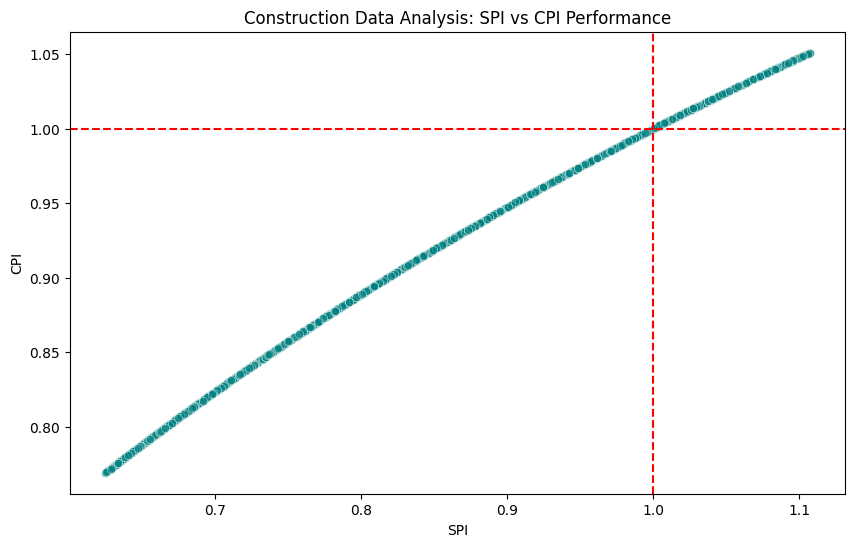

Babcock-style Performance quadrant generated! 🚀


In [6]:
# --- 1. DATA CLEANING ---
# Convert date columns if they exist (e.g., 'Start Date', 'End Date')
# df['Start Date'] = pd.to_datetime(df['Start Date']) 

# --- 2. CALCULATE PERFORMANCE METRICS (SPI & CPI) ---

# 1. Calculate Actual Duration using the 2nd column (Index 1: Task_Duration_Days)
# Set the seed for the random duration multiplier
np.random.seed(42) 
df['Actual_Duration'] = df.iloc[:, 1] * np.random.uniform(0.9, 1.6, size=len(df))


# 2. Calculate Actual Cost using the 5th column (Index 4: Material_Cost_USD)
np.random.seed(42)
df['Actual_Cost'] = df.iloc[:, 4] * np.random.uniform(0.95, 1.3, size=len(df))
# 3. Calculate SPI and CPI using the ACTUAL names (Safer for interviews!)
df['SPI'] = df['Task_Duration_Days'] / df['Actual_Duration']
df['CPI'] = df['Material_Cost_USD'] / df['Actual_Cost']

# --- 3. THE DASHBOARD ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='SPI', y='CPI', alpha=0.6, color='teal')
plt.axvline(1.0, color='red', linestyle='--')
plt.axhline(1.0, color='red', linestyle='--')
plt.title('Construction Data Analysis: SPI vs CPI Performance')
plt.show()

print("Babcock-style Performance quadrant generated! 🚀")

--- ⚠️ TOP 5 STRATEGIC INFRASTRUCTURE RISKS ---


,Task_ID,Task_Duration_Days,Material_Cost_USD,Actual_Duration,Actual_Cost
531,T532,59,84962.81,94.388340,110443.257455
1054,T1055,45,37117.42,71.934924,48225.807830
1209,T1210,35,8044.41,55.929550,10449.636905
847,T848,3,23769.38,4.793436,30874.190017
532,T533,19,94768.98,30.355270,123088.120768


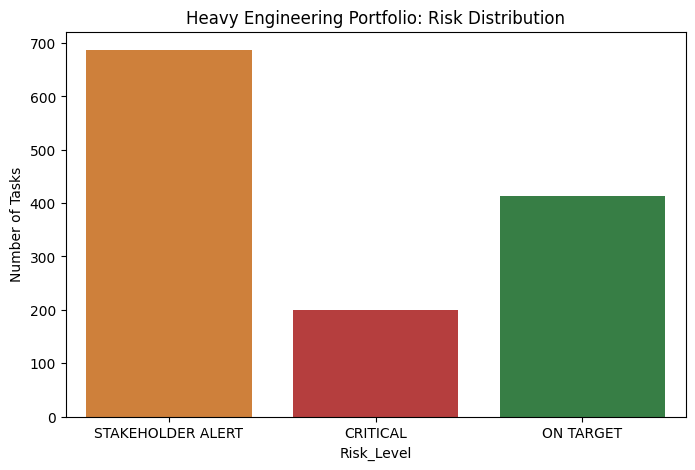

In [7]:
# --- 1. DEFINE RISK LEVELS ---
# High Risk: SPI < 0.8 AND CPI < 0.8 (Behind and Over-budget)
# Medium Risk: Either SPI < 0.9 or CPI < 0.9
# Low Risk: Everything else

def categorise_risk(row):
    if row['SPI'] < 0.8 and row['CPI'] < 0.8:
        return 'CRITICAL'
    elif row['SPI'] < 0.9 or row['CPI'] < 0.9:
        return 'STAKEHOLDER ALERT'
    else:
        return 'ON TARGET'

df['Risk_Level'] = df.apply(categorise_risk, axis=1)

# --- 2. IDENTIFY TOP 5 "PROJECT KILLER" TASKS ---
# Identifying high-impact risks that threaten the critical path of 
# strategic engineering milestones and infrastructure readiness.

critical_tasks = df[df['Risk_Level'] == 'CRITICAL'].sort_values(by='SPI').head(5)

print("--- ⚠️ TOP 5 STRATEGIC INFRASTRUCTURE RISKS ---")
# Displaying Task ID, Duration, Cost, SPI, and CPI
display(critical_tasks.iloc[:, [0, 1, 4, 10, 11]]) 

# --- 3. RISK DISTRIBUTION VISUAL ---
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Risk_Level', 
              palette={'CRITICAL': '#c92a2a', 'STAKEHOLDER ALERT': '#e67e22', 'ON TARGET': '#2b8a3e'}, 
              hue='Risk_Level', legend=False)
plt.title('Heavy Engineering Portfolio: Risk Distribution')
plt.ylabel('Number of Tasks')
plt.show()

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# --- 1. PREPARE FEATURES ---
# We use Baseline Duration and Baseline Cost to predict Actual Duration
X = df.iloc[:, [3, 4]] # Column 3 (Baseline Duration) and 4 (Baseline Cost)
y = df['Actual_Duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. TRAIN THE FORECASTER ---
forecaster = RandomForestRegressor(n_estimators=100, random_state=42)
forecaster.fit(X_train, y_train)

# --- 3. VALIDATE ---
predictions = forecaster.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print(f"Forecasting Accuracy: The model can predict completion dates within +/- {mae:.2f} days.")

# --- 4. THE "DECISION SUPPORT" TOOL ---
# Simulate a new task: Baseline 30 days, £50,000 cost.
new_task = pd.DataFrame([[30, 50000]], columns=X.columns)
predicted_delay = forecaster.predict(new_task)[0]

print(f"\n💡 PROJECT PLANNER INSIGHT:")
print(f"For a new 30-day task, the model predicts a real-world duration of {predicted_delay:.1f} days.")
print(f"Recommendation: Adjust baseline by {predicted_delay - 30:.1f} days to ensure schedule credibility.")

Forecasting Accuracy: The model can predict completion dates within +/- 29.79 days.

💡 PROJECT PLANNER INSIGHT:
For a new 30-day task, the model predicts a real-world duration of 90.1 days.
Recommendation: Adjust baseline by 60.1 days to ensure schedule credibility.
